# Inference of the U2OS interactome

---

This notebook will build up on previous analyses and aims to derive the interactome of the population of U2OS cells. To this end, we will examine different configurations of input graphs, prize assignment and edge weights used in a sensititivity analysis procedure. For each different configuration we will infer the Prize collecting Steiner tree to identify Steiner and terminal nodes which will define the space of the cell-type specific interactome.

---

## 0. Environmental setup

In [3]:
import numpy as np
import pandas as pd
from pcst_fast import pcst_fast
import networkx as nx
import random
from tqdm import tqdm
import community
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import sys
import os

sys.path.append("../../../..")
from src.utils.notebooks.ppi.inference import *

seed = 1234
np.random.seed(seed)
random.seed(seed)

---

## 1. Read in data

First, we load in the preprocessed protein-protein interactome graph.

In [10]:
ppi = nx.read_gpickle(
    "../../../../data/experiments/rohban/interactome/preprocessing/cv/ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv.pkl"
)

In [11]:
ppi_nodes = sorted(list(ppi.nodes()))

In [12]:
spec_results = pd.read_csv(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
orf_targets = set(spec_results.index)
specific_targets = set(spec_results.loc[spec_results["selected"]].index)

---

## 2. Run PCST-based inference

Using the above data, we will approximately solve the PCST problem for different choice of $\beta$ in the PCST objectives, i.e. the prize factor. We aim to identify a stable subgraph from the confidence pruned humna PPI that describes the cell-type specific interactome of U2OS cells best.

We will vary the hyperparameter of beta from 0 to 10 by 0.1 to have a good trade-off of sufficient coverage and run-time.

In [13]:
bs = np.arange(0.1, 10, 0.1)

We will use different metrics for the edge weights, namely the Mint-inspired score-derived edge costs, the costs based on the Spearman correlation from the scRNAseq data set as well as those based on the Pearson correlation.

### 2.1. MINT inspired edge costs

In [14]:
(pcst_mis_dict, augmented_pcst_mis_dict,) = run_pcst_sensitivity_analyses(
    graph=ppi,
    bs=bs,
    prize_key="prize",
    weight_key="mi_score",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 99/99 [00:06<00:00, 14.66it/s]


The function outputs the derived PCST solutions as well as the subgraphs of the input network induced by node set of the PCST solution. 

In [15]:
augmented_pcst_mis_results = analyze_pcst_sensitivity_analyses_results(
    augmented_pcst_mis_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
augmented_pcst_mis_results.loc[
    augmented_pcst_mis_results["n_spec_target_nodes"]
    == np.max(augmented_pcst_mis_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree: 100%|██████████| 99/99 [01:32<00:00,  1.07it/s]


,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_0.6,0.6,348,2316,1,7,13.310345,10.618310,9,101,39,2,12.820513,11.360913
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_0.7,0.7,424,2878,1,8,13.575472,11.349880,10,106,39,2,13.666667,12.304540
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_0.8,0.8,527,3626,1,9,13.760911,12.215481,20,109,39,2,14.974359,13.348364
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_0.9,0.9,621,4314,1,9,13.893720,12.660244,27,112,39,2,15.794872,14.144274
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_1.0,1.0,729,5001,1,10,13.720165,13.001262,39,114,39,2,16.923077,15.359595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.5,9.5,6506,34325,1,23,10.551798,16.921797,1201,175,39,1,41.179487,40.026191
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.6,9.6,6513,34295,1,20,10.531245,16.940933,1207,175,39,1,41.230769,40.153846
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.7,9.7,6548,34523,1,29,10.544594,16.958040,1214,175,39,1,41.256410,40.238212
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.8,9.8,6565,34497,1,25,10.509368,16.944273,1226,175,39,1,41.282051,40.240271


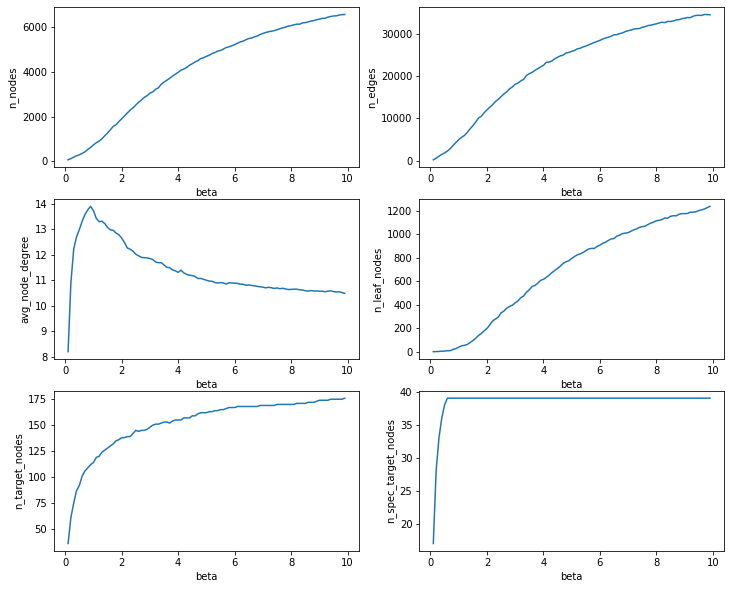

In [16]:
summarize_analyses_results_visually(augmented_pcst_mis_results)

Since we aim to simply learn the interactome that describe the individual specific ORF targets we choose the smallest graph solution that spans all those targets, which is obtained at $\beta$=0.6.

In [17]:
mis_sol = augmented_pcst_mis_dict[
    "augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_0.6"
].copy()
mis_sol.name = "mis_sol"
print(nx.info(mis_sol))

Graph named 'mis_sol' with 348 nodes and 2316 edges


<ipython-input-17-a653ff67ed72>:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(mis_sol))


The corresponding network consists of 348 nodes with an average degree of 13.31 stemming from 2'316 edges. The network covers all 39 structural regulator genes covered in the input graph.

---

### 2.2. Spearman correlation edge weights

After having inferred the solution using the MINT-score inspired edge costs, we will now rerun the analyses using $1-r_{Spearman}$ as an alternative edge weight defintion. The intuition is that this will further guide the derivation of the interactome to focus on links that are specific to our cell-type of interest. On the flip side the metric were computed on noisy scRNAseq data which might limit the descriptive power of this metric to evaluate the strength of a regulatory link.

Since the Spearman-based edge weights are in the range of [0,1] compared to those previously used for MINT score based ones [0,0.594], we will run the screen for $\beta \in$ [0,20].

In [18]:
bs = np.arange(0.1, 10, 0.1)

In [29]:
edge_attr_dict = list(ppi.edges(data=True))[0][2]
if "spearmanr" in edge_attr_dict:
    spearmanr_id = "spearmanr"
else:
    spearmanr_id = "scgex_spearmanr"

In [30]:
(pcst_spearman_dict, augmented_pcst_spearman_dict,) = run_pcst_sensitivity_analyses(
    graph=ppi,
    bs=bs,
    prize_key="prize",
    weight_key=spearmanr_id,
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 99/99 [00:05<00:00, 17.54it/s]


In [31]:
augmented_pcst_spearman_results = analyze_pcst_sensitivity_analyses_results(
    augmented_pcst_spearman_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
augmented_pcst_spearman_results.loc[
    augmented_pcst_spearman_results["n_spec_target_nodes"]
    == np.max(augmented_pcst_spearman_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree:   0%|          | 0/99 [00:00<?, ?it/s]/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret

,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_2.6,2.6,249,526,1,9,4.224900,4.062467,55,47,39,7,5.076923,4.816556
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_2.7,2.7,269,565,1,9,4.200743,4.077848,63,48,39,7,5.358974,5.096440
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_2.8,2.8,310,681,1,11,4.393548,4.246436,71,49,39,6,5.743590,5.591743
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_2.9,2.9,336,757,1,11,4.505952,4.295619,75,49,39,6,5.948718,5.674725
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_3.0,3.0,346,755,1,11,4.364162,4.207795,78,50,39,7,5.923077,5.779649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.5,9.5,3337,13288,1,17,7.964040,11.810735,728,117,39,1,24.923077,24.040974
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.6,9.6,3380,13457,1,18,7.962722,11.834251,738,117,39,1,24.974359,24.167670
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.7,9.7,3424,13761,1,21,8.037967,11.962938,736,118,39,1,25.282051,24.286694
augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_9.8,9.8,3470,13982,1,23,8.058790,12.026172,744,117,39,1,25.384615,24.434754


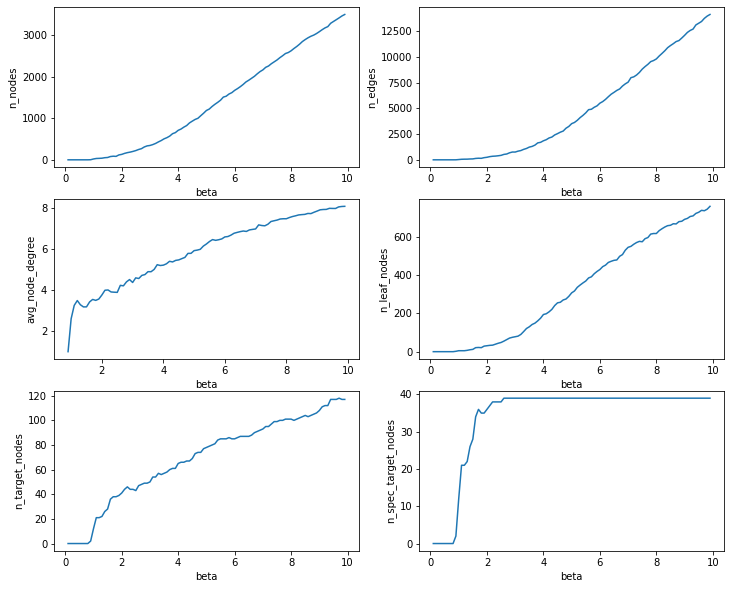

In [32]:
summarize_analyses_results_visually(augmented_pcst_spearman_results)

Using the Spearman-correlation based ede weights we see much smaller rate of increase of the number of edges and nodes for the different choices of $\beta$. This can be explained by the heavily left-skewed distribution of the Spearman edge weights when compared to the more uniformly distributed MINT score based edge weights used previously. We see that for a choice of $\beta \geq 2.6$ all 41 specific ORF targets are covered. Thus, we choose the corresponding graph as the solution of this setup.

In [33]:
spearman_sol = augmented_pcst_spearman_dict[
    "augmented_ppi_confidence_0594_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv_b_2.6"
].copy()
spearman_sol.name = "spearman_sol"
print(nx.info(spearman_sol))

Graph named 'spearman_sol' with 249 nodes and 526 edges


<ipython-input-33-fad31068561f>:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(spearman_sol))


The selected network consists of 249 nodes with an average degree of 4.225 stemming from 526 edges. It is much sparser compared to the solution obtained by using the MIscore edge weights.

---

### 2.3 Comparison of the MIscore and Spearman edge cost solutions

To compare the solutions with the ones obtained previously for the MINT score based edge weights, we will look at the IoU of the nodes set of those two for the different choices of $\beta$.

100%|██████████| 99/99 [00:35<00:00,  2.75it/s]


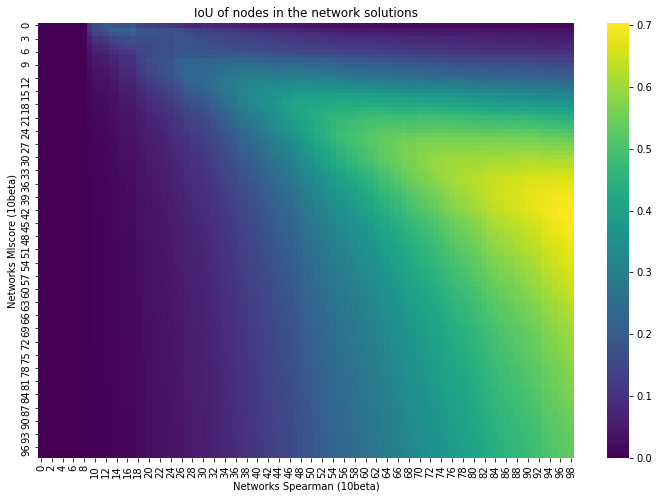

In [34]:
fig, ax, mis_spearman_node_ious = plot_solution_node_ious(
    augmented_pcst_mis_dict,
    augmented_pcst_spearman_dict,
    xlabel="Networks Spearman (10beta)",
    ylabel="Networks MIscore (10beta)",
)
plt.show()

As seen in the above plot the IoU is becomes relatively high for large $\beta$ values, i.e. for $\beta \geq (4,12)$ for the MIscore based edge weights and the Spearman edge weights respectively.

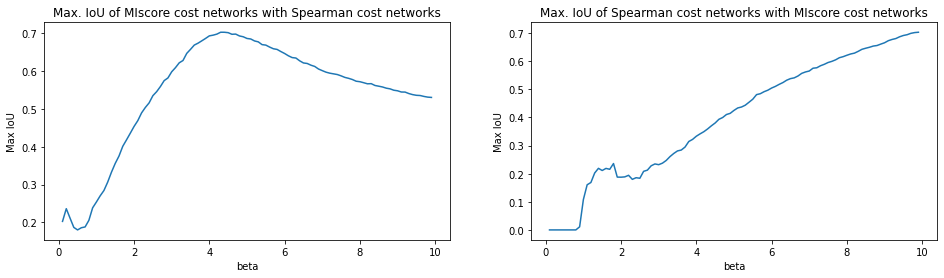

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=[16, 4])
ax = ax.flatten()
ax[0].plot(np.arange(0.1, 10, 0.1), np.max(mis_spearman_node_ious, axis=1))
ax[0].set_xlabel("beta")
ax[0].set_ylabel("Max IoU")
ax[0].set_title("Max. IoU of MIscore cost networks with Spearman cost networks")
ax[1].plot(np.arange(0.1, 10, 0.1), np.max(mis_spearman_node_ious, axis=0))
ax[1].set_xlabel("beta")
ax[1].set_ylabel("Max IoU")
ax[1].set_title("Max. IoU of Spearman cost networks with MIscore cost networks")
plt.show()

The plots above also indicate that for choices of $\beta \leq (2.1, 5.9)$ the IoU of the node sets is upper bounded by 0.5.

This shows, that the PCST solutions for moderate choices of $\beta$ are quite different. Thus, we will consider both solutions in our further anlayses, i.e. the networks obtained for a choice of $\beta=0.6$ for the MIscore edge cost network and $\beta=2.6$ for the Spearman correlation edge cost network.

---

## 3. Output U2OS interactome candidate

Based on our previous analyses, we select our four interactome candidates.

The first network is the one that we obtained by that we obtained for $\beta=0.6$ by running the PCST using the ``conf_hub_ppi`` as the input graph with the prizes being the min-max scaled absolute log fold-changes from the marker screen based on the CCLE data set and the edge weights being given by the $1-m(e)$ where $m(e)$ is the MINT-inspired score for the interaction of the nodes connected by edge $e$.

The second network is the one that we obtained for the same setup but selecting $\beta=1.2$ to further outgrow the network.

The third and forth network are obtained by a similar setup but the edge weights are here given by $1-m(e)$ where $(e)$ is the absolute Spearman correlation of the scRNAseq data between the two genes.

In [36]:
print(nx.info(mis_sol))

print("")
print(nx.info(spearman_sol))

Graph named 'mis_sol' with 348 nodes and 2316 edges

Graph named 'spearman_sol' with 249 nodes and 526 edges


<ipython-input-36-63ab7b6a457c>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(mis_sol))
<ipython-input-36-63ab7b6a457c>:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(spearman_sol))


In [37]:
ggi_nodes = sorted(list(spearman_sol.nodes()))
node_selection_df = pd.DataFrame(
    np.zeros(len(ppi_nodes)), columns=["selected_in_ggi"], index=ppi_nodes
)
node_selection_df.loc[ggi_nodes] = 1

In [38]:
output_dir = "../../../../data/experiments/rohban/interactome/inference_results"
os.makedirs(output_dir, exist_ok=True)
nx.write_graphml(
    mis_sol,
    os.path.join(output_dir, "{}_cv.graphml".format(mis_sol.name)),
)
nx.write_gpickle(
    mis_sol,
    os.path.join(output_dir, "{}_cv.pkl".format(mis_sol.name)),
)

In [39]:
nx.write_graphml(
    spearman_sol,
    os.path.join(output_dir, "{}_cv.graphml".format(spearman_sol.name)),
)
nx.write_gpickle(
    spearman_sol,
    os.path.join(output_dir, "{}_cv.pkl".format(spearman_sol.name)),
)

In [40]:
node_selection_df.to_csv(os.path.join(output_dir, "node_selection.csv"))